In [1]:
# pip install -i https://test.pypi.org/simple/ VASA

In [1]:
import pandas as pd
import geopandas as gpd

import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.pardir)))

from VASA import VASA

In [2]:
# import the data file:
data = pd.read_csv("../test data/lakefire.csv")

# need to ensure that these GEOID's match the ones in our GeoDataFrame
data.origin_census_block_group = "0" + data.origin_census_block_group.astype(str)

data.head()

,origin_census_block_group,date_range_start,distance_traveled_from_home
0,060372713005,2019-07-15 07:00:00,742
1,060372766041,2019-07-15 07:00:00,1799
2,060374334012,2019-07-15 07:00:00,1884
3,060375017003,2019-07-15 07:00:00,2334
4,060375322002,2019-07-15 07:00:00,2791


In [3]:
fire_map = gpd.read_file("../test data/ca_cbgs.geojson") \
    .set_crs(epsg=4326) \
    .to_crs("+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs")

fire_map = fire_map[fire_map["ALAND"] > 0]

islands_to_exclude = [
    # ---------------
    "060375991001", 
    # Catalina Island
    "060375990001",
    "060375990002",
    "060375990003",
    "060375990004",
    "060375991002"
]

fire_map = fire_map[~fire_map.GEOID.isin(islands_to_exclude)]

fire_map.head()

,ALAND,GEOID,geometry
0,274050,060371044041,"POLYGON ((-1944035.709 -442424.821, -1943863.2..."
1,873636,060371047031,"POLYGON ((-1942149.424 -444386.366, -1941970.9..."
2,136553,060371249032,"POLYGON ((-1944179.245 -454239.078, -1944134.0..."
3,294603,060371047032,"POLYGON ((-1942525.758 -444096.575, -1942336.8..."
4,681800,060371047041,"POLYGON ((-1942660.860 -443120.165, -1942657.7..."


In [ ]:
fire_map.plot()

![CBG Map of Southern California](./cbg_map_so_cal.png)

In [4]:
v = VASA(
    df=data,
    gdf=fire_map,
    group_summary=lambda g: g[:9], # census tract
    df_group_col="origin_census_block_group",
    gdf_group_col="GEOID",
    date_col="date_range_start",
    temp_res="week",
    date_format="%Y-%m-%d %H:%M:%S"
)

In [5]:
v.filter_group().group()

## Look at missing values:

In [18]:
v.pct_partial_missing()

array([0.04558578])

In [19]:
v.pct_full_missing()

array([19.76903206])

In [6]:
v.fill_missing()

In [21]:
v.pct_full_missing(), v.pct_partial_missing()

(array([0.]), array([0.]))

## Find the weights connection to use:

In [ ]:
v.show_weights_connection(k=7)

![Lakefire KNN spatial weights](./lakefire_knn_weights.png)

In [ ]:
v.show_weights_connection(type="queens")

![Lakefire queens spatial weights](lakefire_queens_weights.png)

c:\MOVE\VASA\myenv\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
c:\MOVE\VASA\myenv\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 3523.
  warnings.warn(message)


(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

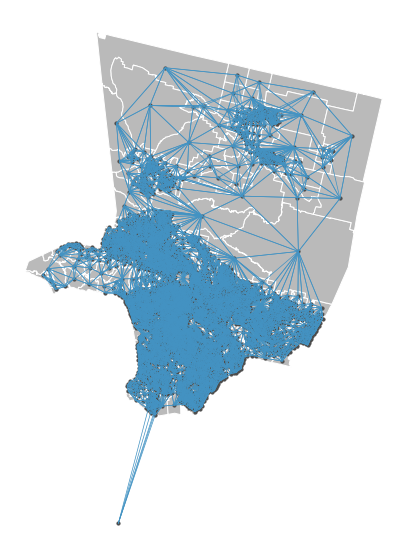

In [10]:
v.show_weights_connection(k=5, type="union")

![Lakefire Queens and Knn spatial weights](./lakefire_union_weights.png)

## LISA

In [7]:
v.lisa(k=5, type="union")

c:\MOVE\VASA\myenv\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
from scipy.stats import mode
from typing import List

from VASA.vasa import VASA
from VASA.BasePlot import BasePlot


class Scatter(BasePlot):

    def __init__(self, v: VASA, desc=None, figsize=(0, 0), titles: str or List[str] = None):
        """
        Create the scatter plot object.

        Parameters
        ----------
        v: VASA
            VASA object where the lisa() method has been called.
        desc: str
            Plot description used when saving to a file
        figsize: (float, float)
            Matplotlib figsize specification. Leave as (0, 0) to default
            to (n_rows * 4, n_cols * 4).
        titles: str | List[str]
            String (optional for a single plot) or list of strings to give as titles
            to the scatter plots. Defaults as the column name
        """
        if not v._ran_lisa:
            raise Exception("VASA object has not ran the lisa method yet")

        super().__init__("scatter")

        self.v: VASA = v
        self.plotted = False
        self.fontsize = 14
        self._desc = desc if desc else "-".join(v.cols)

        cols = v.cols
        if titles and len(titles) == len(cols):
            if not isinstance(titles, list):
                titles = [titles]
        else:
            titles = cols
        self.titles = titles

        n_cols = math.ceil(len(cols) / 2)
        n_rows = min(len(cols), 2)

        self.n_cols = n_cols
        self.n_rows = n_rows
        self.figsize = ((n_rows * 4, n_cols * 4)
                        if figsize[0] * figsize[1] <= 0 else figsize)

    def plot(self, highlight: str = "", show: bool = True, add_noise: bool = False, samples = 0, group=False):
        """
        Creates a scatter plot showing hot/cold LISA classifications over
        the time period.

        Parameters
        ----------
        highlight: str
            Geometry group to draw lines for. This value should match
            with a v.group_summary() result. Example: geometries are at
            the county level and the v.group_summary() function returns the
            state code. Then `highlight` should be a two digit number as a
            string specifying the state to highlight the counties of.
        show: bool = True
            Whether to show the plot or save the file.
        add_noise: bool = True
            Add noise to differentiate lines
        """
        fig, axes = plt.subplots(
            self.n_cols,
            self.n_rows,
            figsize=self.figsize,
            sharex=True,
            sharey=True
        )
        self.fig = fig
        self.axes = [axes] if len(self.v.cols) == 1 else axes.flatten()

        count = self.v.reduce("count")
        recent = self.v.reduce('recency')

        df = count.merge(
            recent,
            left_on="fips",
            right_on="fips",
            how="inner",
            suffixes=("_count", "_recency")
        ).reset_index(drop=True)

        if df.shape[0] == 0:
            return

        if highlight != "":
            df = df[[
                self.v.group_summary(c) == highlight for c in df.fips.values
            ]].reset_index(drop=True)

        if samples > 0:
            to_incl = np.random.choice(np.arange(0, df.shape[0]), size=samples, replace=False)
            df = df.iloc[to_incl, :].reset_index(drop=True)

        for i, ax in enumerate(self.axes):
            col: str = self.v.cols[i]
            title = self.titles[i] if self.titles and len(
                self.titles) >= i + 1 else col

            points = df[[f"{col}_count", f"{col}_recency"]].copy()
            points["count"] = [
                max(c)
                for c in points[f"{col}_count"]
            ]
            points["which"] = [
                (1 if h > c else (np.nan if h == 0 and c == 0 else 0))
                for h, c in points[f"{col}_count"]
            ]
            points = points.rename(
                {f"{col}_recency": "recent"},
                axis="columns"
            )

            points = points[["recent", "count", "which"]].dropna().groupby(
                ["count", "recent"]).agg(np.mean).reset_index()

            if highlight != "" or group:
                self.__draw_lines(highlight, col, ax,
                                  df[[f"{col}_count", "fips"]], f"{col}_count", add_noise, group)

            self.__create_scatter(ax, points, zorder=10)
            self.__axis_format(ax)

            ax.set_title(title)

        self.plotted = True

        if not show:
            super().save_plot(self._desc, '')
            plt.close()

    def __draw_lines(self, highlight, col, ax, df, c, add_noise, group):
        
        # df = df[[self.v.group_summary(f) == highlight for f in df.fips]].reset_index(drop=True)
        to_select = [f in df.fips.values for f in self.v.fips_order]

        lines = np.array(self.v.df[col].tolist())[:, to_select]

        if group:
            group_order = np.array([self.v.group_summary(f) for f in self.v.fips_order])[to_select]
            groups = np.unique(group_order)
            
            output = np.empty((lines.shape[0], len(groups)))

            for i, g in enumerate(groups):
                group_sel = np.where(group_order == g)[0]
                output[:, i] = mode(lines[:, group_sel], axis=1).mode[:, 0]

            lines = output

        lines_rev = lines[::-1, :]
        lines_order = np.argsort(
            lines.shape[0] - np.argmax(lines_rev == 1, axis=0) - 1)
        
        colors = [(1 if a > b else 2) for a, b in df[c]]
        alpha = 1 / len(lines)
        for i in lines_order[::-1]:
            val = colors[i]
            if val == 0:
                continue
            color = "red" if val == 1 else "blue"
            self.__draw_line(ax, lines[:, i], val,
                             color, min(1, alpha), add_noise)

    def __draw_line(self, ax, xs, val, color, alpha, add_noise):
        sig_vals = (xs == val) + 0
        sig_idcs = np.where(sig_vals == 1)[0]

        if len(sig_idcs) == 0:
            return

        start = max(sig_idcs[0] - 1, 0) if len(sig_idcs) > 0 else 0
        stop = sig_idcs[-1] + 1

        # stop line at list sig value
        xs = xs[start:stop]

        ys = np.cumsum(xs == val)

        if add_noise:
            ys = ys + np.random.normal(0, 0.125, len(ys))

        ax.plot(
            np.arange(start + 1, stop + 1),
            # + np.random.normal(0, 1/16, size=len(xs)),
            ys,
            c=color,
            alpha=alpha
        )

    def __create_scatter(self, ax, df: pd.DataFrame, **kwargs):
        sns.scatterplot(
            x="recent",
            y="count",
            data=df,
            hue="which",
            palette="bwr",
            ax=ax,
            s=30,
            **kwargs
        )

    def __axis_format(self, ax):
        _, max_x = ax.get_xlim()
        ax.set_xlim(0, max_x)
        ax.set_ylim(0, max_x)
        ax.grid(False)

        ax.set_ylabel("Count", fontsize=self.fontsize)
        ax.set_xlabel("Last Week Number", fontsize=self.fontsize)

        import matplotlib.patches as mpatches

        hot_spot = mpatches.Patch(color="red", label="Hotspot")
        cold_spot = mpatches.Patch(color="blue", label="Coldspot")

        ax.legend(handles=[hot_spot, cold_spot])


In [120]:
from VASA.scatter import Scatter
sc = Scatter(v)

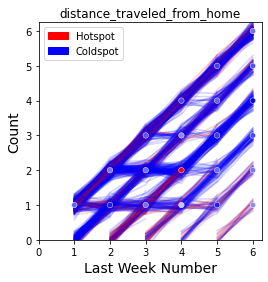

In [121]:
# one line per census tract ~1,000 census tracts still (~6500 cbgs)
# census track value is created by mode of weekly value of the the cbgs in the tract
sc.plot(group=True, add_noise=True)

Number of samples: 100
(100, 3)
Number of samples: 150
(150, 3)
Number of samples: 250
(250, 3)
Number of samples: 500
(500, 3)
Number of samples: 750
(750, 3)
Number of samples: 1000
(1000, 3)


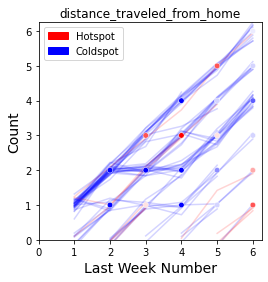

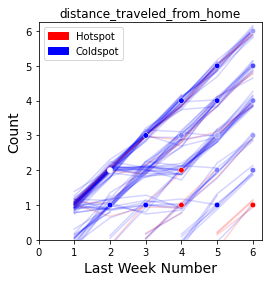

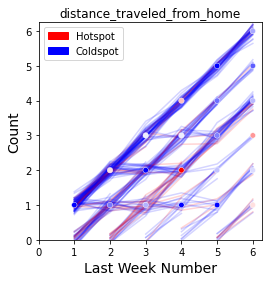

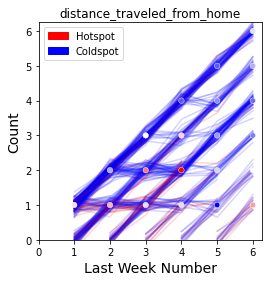

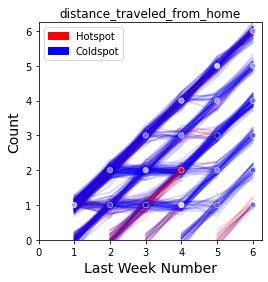

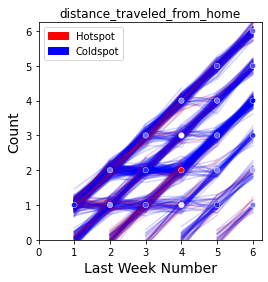

In [122]:
for sample in [100, 150, 250, 500, 750, 1000]:
    print(f"Number of samples: {sample}")
    sc.plot(highlight = "06037", samples=sample, add_noise=True)

(6581, 3)


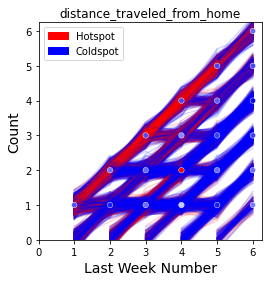

In [12]:
# Highlight values in LA County:
sc.plot(highlight = "06037", add_noise=True)

In [23]:
from VASA.static_choropleth import StackedChoropleth
stcked = StackedChoropleth(v, titles="Distance Traveled From Home")

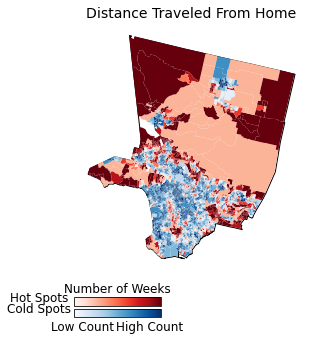

In [24]:
stcked.plot_count()

In [ ]:
stcked.plot_count(show=False)

![Lakefire count stacked choropleth](./stacked/number_of_weeks/distance_traveled_from_home.png)

In [19]:
stcked.plot_recent(show=False)

![](./stacked/recency/distance_traveled_from_home.png)

In [20]:
stcked.plot_both(a=250, b=75, show=False)

![Lakefire combined stacked choropleth](./stacked/combined/distance_traveled_from_home.png)

In [18]:
stcked.plot_bivar(show=False)

![Lakefire bivar stacked choropleth](./stacked/bivar/distance_traveled_from_home.png)